In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

In [2]:
#directories
dataset_name = 'field_dataset'
dataset_dir = f'datasets/{dataset_name}'
output_dir ="output"
g_matrix_filename = f"G_{dataset_name}.npy" #Name of the file where matrix G will be saved
gamma_filename = f"gamma_{dataset_name}.npy"
weight_matrix_filename = f"w_{dataset_name}.npy"

In [3]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [4]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

#Load G matrix
G = np.load(os.path.join(output_dir,g_matrix_filename))
gamma = np.load(os.path.join(output_dir,gamma_filename))
weight_matrix = np.load(os.path.join(output_dir,weight_matrix_filename))

In [5]:
def buildAndPrintGraph(gamma, weight_matrix):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i,image = imgs[i])
    for i in range(n): 
         for j in range(n): 
            if gamma[i,j] == 1:
                G.add_edge(i,j, weight=weight_matrix[i,j]) 
    pos=nx.circular_layout(G)
    fig=plt.figure(figsize=(15,15))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw(G,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    piesize=0.08 # this is the image size
    p2=piesize/0.9 #this is the image center
    for g in G:
        xx,yy=trans(pos[g]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[g]['image'])
        a.axis('off')
    ax.axis('off')
    plt.show()
    return G

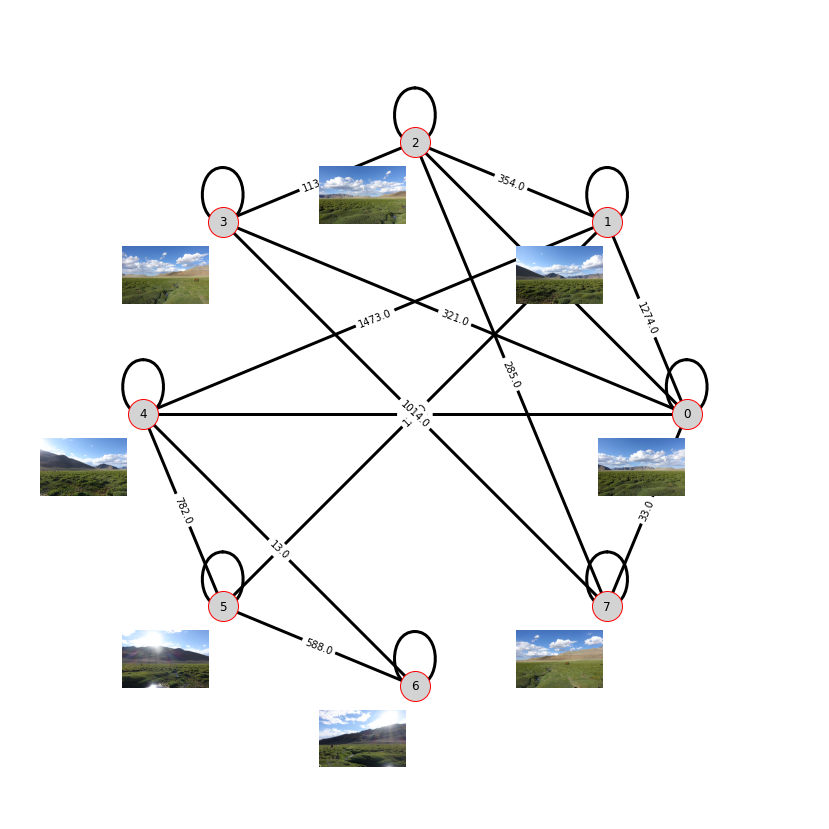

In [6]:
graph = buildAndPrintGraph(gamma = gamma, weight_matrix = weight_matrix)

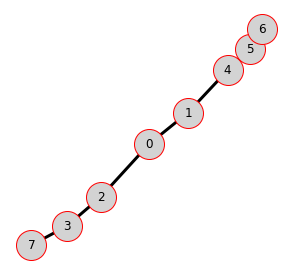

In [7]:
spanning_tree = nx.maximum_spanning_tree(graph)
pos=nx.kamada_kawai_layout(spanning_tree)
fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw(spanning_tree,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
plt.show()


In [8]:
class Kmeans:
    def __init__(self, k=2, init_mode = "random"):  
        self.k=k
        self.init_mode = init_mode

    
    def fit(self, graph):
        if self.k > len(graph.nodes):
            raise Exception("K greater than the nodes!")
        self.graph = graph
        self.centroids = self.__init_centroids(mode = self.init_mode)
        self.old_centroids = self.centroids
        self.cluster = np.zeros(len(self.graph.nodes), dtype=int)
        self.distances = dict(nx.all_pairs_shortest_path_length(self.graph))
        
        while True:
            self.__assign_cluster()
            self.__update_centroids()
            if (self.old_centroids==self.centroids).all():
                return self.cluster
            self.old_centroids = self.centroids
        
            
        
    def __init_centroids(self, mode="random"):             
        if mode =="random":
            return np.random.choice(self.graph.nodes,self.k,replace=False)
            
        if mode =="leaves":
            spanning_tree = nx.maximum_spanning_tree(self.graph)
            leaves = []
            for node in self.graph.nodes:
                if len(spanning_tree[node])==1: #leaf
                    leaves.append(node)
            if len(leaves)>self.k:
                leaves=np.random.choice(leaves,self.k,replace=False)
            while len(leaves)<self.k:
                pseudo_leaf = np.random.choice(self.graph.nodes,1, replace=False)[0]
                if pseudo_leaf not in leaves:
                    leaves.append(pseudo_leaf)
            return np.array(leaves, dtype=int)
        
        return self.__init_centroids(mode="random")
    
            
    def __assign_cluster(self):
        for node in self.graph.nodes:
            if node in self.centroids:
                self.cluster[node] = np.where(self.centroids==node)[0]
            else:
                self.cluster[node] = 0
                min_distance, max_matches = self.__distance_from_centroid(node, self.centroids[0]) 
                for centroid in self.centroids[1:]:
                    distance, matches = self.__distance_from_centroid(node, centroid)
                    if distance<min_distance or (distance==min_distance and matches>max_matches):
                        self.cluster[node] = np.where(self.centroids==centroid)[0]
                        min_distance = distance
                        max_matches = matches
                                   
    
    def __distance_from_centroid(self, node, centroid):
        distance = self.distances[node][centroid]
        matches = 0
        if distance==1:
            matches = (self.graph.edges[node,centroid]["weight"] + self.graph.edges[centroid,node]["weight"])/2
        return distance, matches
                    
    def __update_centroids(self):
        for i in range(len(self.centroids)):
            elements_in_centroid = [j for j, x in enumerate(self.cluster) if x == i]
            min_distance = 0
            for node in elements_in_centroid:
                distance = np.mean([self.distances[node][d] for d in elements_in_centroid])
                if distance<min_distance:
                    min_distance = distance
                    self.centroids[i] = node
    


        

In [9]:
kmeans = Kmeans(k=2, init_mode="leaves")

In [10]:
cluster = kmeans.fit(graph)

In [11]:
cluster

array([1, 0, 1, 1, 0, 0, 0, 1])

In [12]:
cluster

array([1, 0, 1, 1, 0, 0, 0, 1])

In [13]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

In [14]:
gamma

array([[1., 1., 1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1., 1., 1., 0.],
       [0., 1., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 0., 0., 1.]])

In [15]:
weight_matrix

array([[   0., 1256., 1836.,  338.,  151.,    0.,    0.,   32.],
       [1274.,    0.,  360.,    0., 1476.,  120.,    0.,    0.],
       [1832.,  354.,    0., 1179.,    0.,    0.,    0.,  302.],
       [ 321.,    0., 1136.,    0.,    0.,    0.,    0., 1016.],
       [ 145., 1473.,    0.,    0.,    0.,  798.,   13.,    0.],
       [   0.,  123.,    0.,    0.,  782.,    0.,  613.,    0.],
       [   0.,    0.,    0.,    0.,   13.,  588.,    0.,    0.],
       [  33.,    0.,  285., 1014.,    0.,    0.,    0.,    0.]])

In [16]:
distances = weight_matrix.copy()
maxx = np.max(distances)
print(maxx)

mask = distances != 0
distances[mask] = maxx / distances[mask]

1836.0


In [17]:
distances

array([[  0.        ,   1.46178344,   1.        ,   5.43195266,
         12.1589404 ,   0.        ,   0.        ,  57.375     ],
       [  1.4411303 ,   0.        ,   5.1       ,   0.        ,
          1.24390244,  15.3       ,   0.        ,   0.        ],
       [  1.00218341,   5.18644068,   0.        ,   1.55725191,
          0.        ,   0.        ,   0.        ,   6.0794702 ],
       [  5.71962617,   0.        ,   1.61619718,   0.        ,
          0.        ,   0.        ,   0.        ,   1.80708661],
       [ 12.66206897,   1.24643585,   0.        ,   0.        ,
          0.        ,   2.30075188, 141.23076923,   0.        ],
       [  0.        ,  14.92682927,   0.        ,   0.        ,
          2.34782609,   0.        ,   2.99510604,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        141.23076923,   3.12244898,   0.        ,   0.        ],
       [ 55.63636364,   0.        ,   6.44210526,   1.81065089,
          0.        ,   0.       

In [18]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",connectivity=gamma,linkage="average").fit(distances)

In [19]:
clustering.labels_

array([7, 6, 4, 5, 3, 1, 2, 0], dtype=int64)

In [20]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix 

In [21]:
linkage_matrix = get_linkage_matrix(clustering)

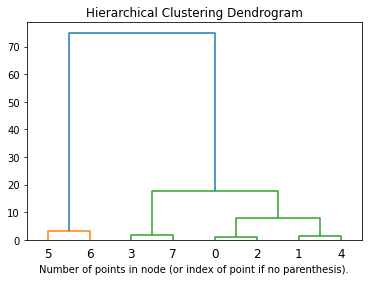

In [22]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
den = dendrogram(linkage_matrix, truncate_mode=None) # truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [23]:
inconsistency = inconsistent(linkage_matrix, d=3)

for i in reversed(range(1,n)):
    print("from %d to %d => Inconsistency %.3f"%(i,i+1,inconsistency[-i,3]))

from 7 to 8 => Inconsistency 0.000
from 6 to 7 => Inconsistency 0.000
from 5 to 6 => Inconsistency 0.000
from 4 to 5 => Inconsistency 0.000
from 3 to 4 => Inconsistency 1.154
from 2 to 3 => Inconsistency 1.647
from 1 to 2 => Inconsistency 1.752


In [24]:
k_inc = inconsistency[:,3][::-1].argmax() + 1
print("The number of cluster suggested using Inconsistency is %d"%(k_inc))

The number of cluster suggested using Inconsistency is 1


In [25]:
den

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [30.0, 30.0, 60.0, 60.0],
  [10.0, 10.0, 45.0, 45.0]],
 'dcoord': [[0.0, 3.122448979591837, 3.122448979591837, 0.0],
  [0.0, 1.8106508875739644, 1.8106508875739644, 0.0],
  [0.0, 1.002183406113537, 1.002183406113537, 0.0],
  [0.0, 1.2464358452138493, 1.2464358452138493, 0.0],
  [1.002183406113537,
   7.741526228039634,
   7.741526228039634,
   1.2464358452138493],
  [1.8106508875739644,
   17.610918692448585,
   17.610918692448585,
   7.741526228039634],
  [3.122448979591837,
   75.01557258530943,
   75.01557258530943,
   17.610918692448585]],
 'ivl': ['5', '6', '3', '7', '0', '2', '1', '4'],
 'leaves': [5, 6, 3, 7, 0, 2, 1, 4],
 'color_list': ['C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2']}

In [31]:
k = len(list(dict.fromkeys(den["leaves_color_list"]))) + max(den["leaves_color_list"].count('C0') - 1, 0 )
k

2

In [32]:
cluster = fcluster(linkage_matrix, k, criterion='maxclust')
cluster

array([2, 2, 2, 2, 2, 1, 1, 2], dtype=int32)

In [33]:
clusters_graph = graph.copy()
for e in graph.edges():
    n1 = e[0]
    n2 = e[1]
    if(cluster[n1] != cluster[n2]):
        clusters_graph.remove_edge(n1,n2)

In [34]:
def plot_graph(G,ax):
    pos=nx.circular_layout(G)
    ax.set_aspect('equal')
    nx.draw(G,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,ax=ax,edge_labels=labels)
 
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    piesize=0.08 # this is the image size
    p2=piesize/0.9 #this is the image center
    for g in G:
        xx,yy=trans(pos[g]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[g]['image'])
        a.axis('off')
    ax.axis('off')


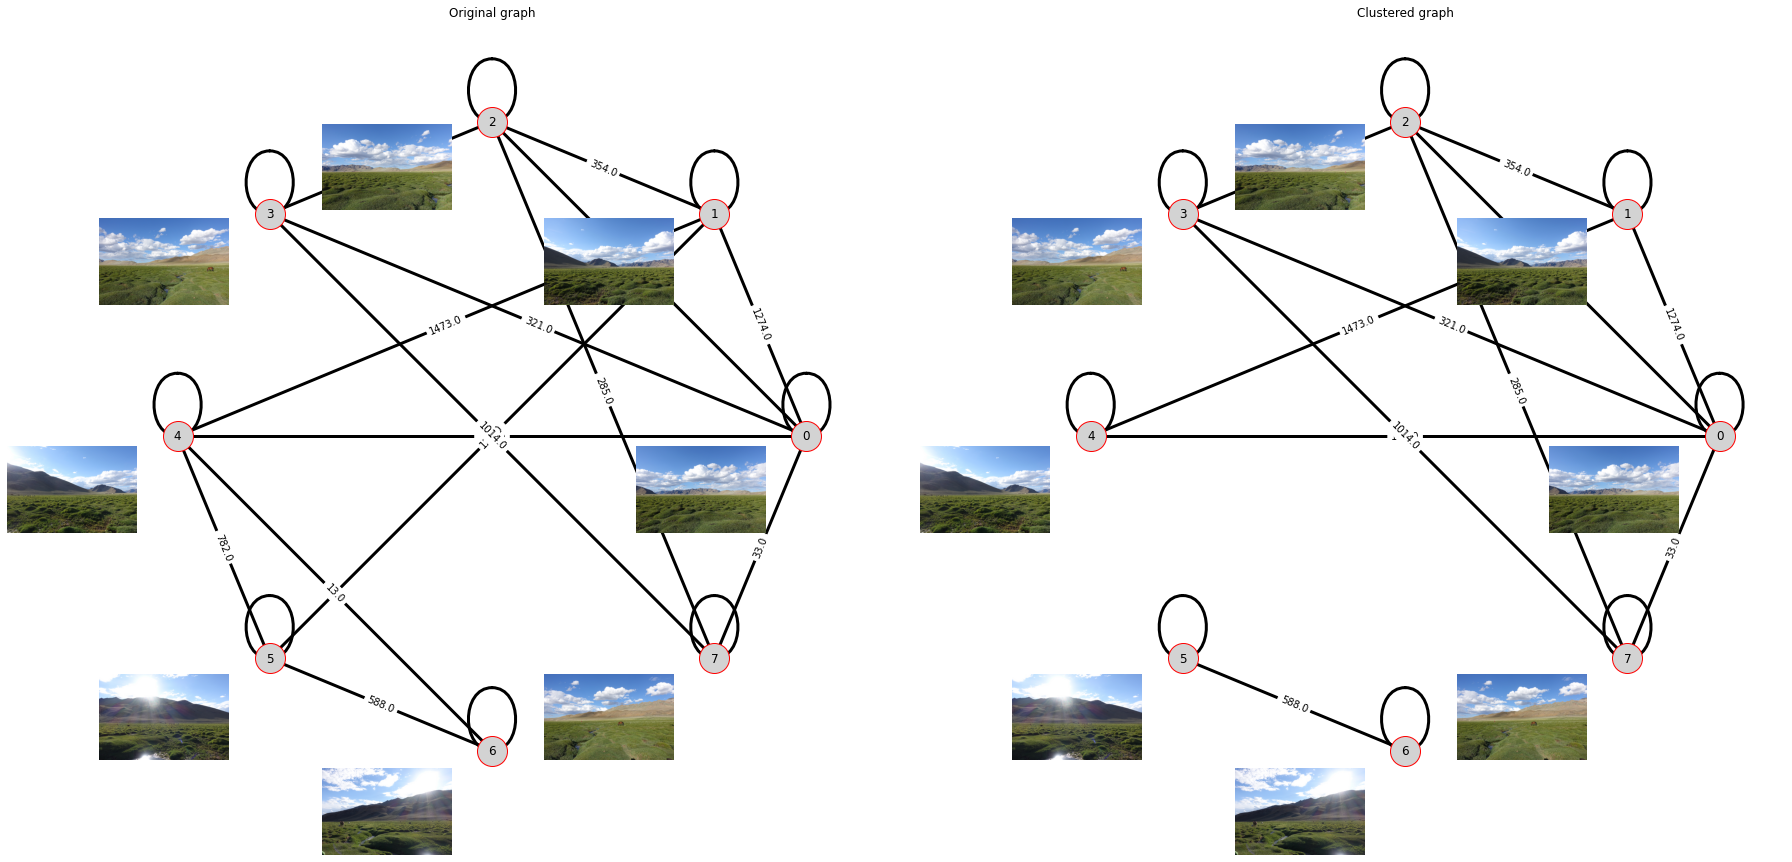

In [35]:
fig=plt.figure(figsize=(30,15))
(ax1,ax2)=fig.subplots(1, 2, sharey=True)
ax1.set_title('Original graph')
plot_graph(graph,ax1)

ax2.set_title('Clustered graph')
plot_graph(clusters_graph,ax2)

plt.show()